# 심부전 임상 기록 데이터 분석 (Heart Failure Clinical Records Analysis)

## 1. 개요
이 노트북은 심부전 임상 기록 데이터(`heart_failure_clinical_records_dataset.csv`)를 분석하여 환자의 사망 여부(`DEATH_EVENT`)를 예측하는 모델을 구축하는 과정을 담고 있습니다.
**OSEMN** (Obtain, Scrub, Explore, Model, iNterpret) 방법론을 따르며, **Random Forest** 알고리즘을 사용합니다.

## 2. 라이브러리 임포트 (Imports)
데이터 분석 및 모델링에 필요한 필수 라이브러리를 로드합니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 시각화 스타일 설정
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 3. 데이터 로드 및 확인 (Obtain)
데이터셋을 로드하고 구조와 기초 통계량을 확인합니다.

In [2]:
# 데이터 로드
df = pd.read_csv('../../data/heart_failure_clinical_records_dataset.csv')

# 상위 5개 행 확인
display(df.head())

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
# 데이터 정보 확인 (결측치 및 타입)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [4]:
# 기초 통계량 확인
display(df.describe())

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


### 데이터 확인 결과
- 총 299개의 샘플과 13개의 컬럼으로 구성되어 있습니다.
- 결측치(Null)는 없는 것으로 보이며, 모든 변수가 수치형(int, float)입니다.
- 타겟 변수는 `DEATH_EVENT` 입니다.

## 4. 탐색적 데이터 분석 (Explore)
데이터의 분포와 변수 간의 관계를 시각적으로 탐색합니다.

### 4.1 타겟 변수 (`DEATH_EVENT`) 분포
데이터의 클래스 불균형 여부를 확인합니다.

/var/folders/7l/yp5d25zx7nb_92wbp8w2b0dw0000gn/T/ipykernel_60209/3889634919.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='DEATH_EVENT', data=df, palette='viridis')


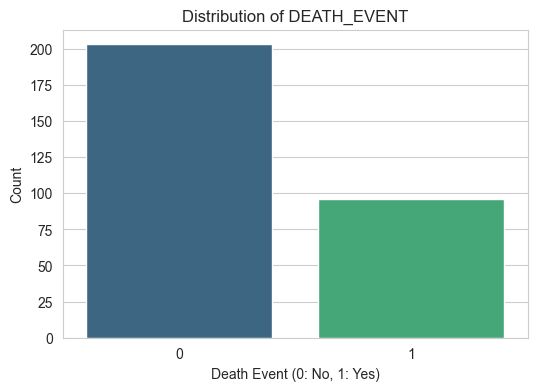

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(x='DEATH_EVENT', data=df, palette='viridis')
plt.title('Distribution of DEATH_EVENT')
plt.xlabel('Death Event (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

### 4.2 상관관계 분석 (Correlation Matrix)
변수들 간의 상관관계를 히트맵으로 확인합니다.

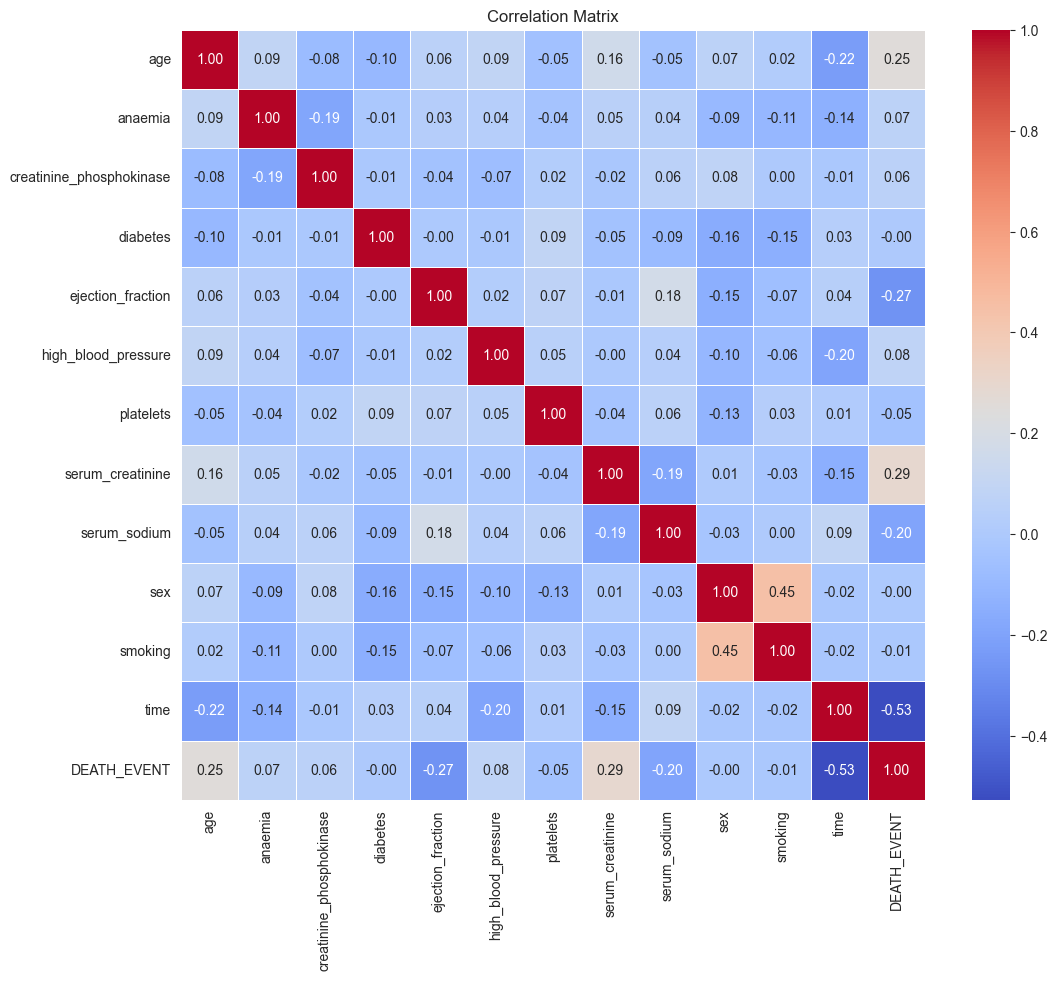

In [6]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### 4.3 연령에 따른 사망 여부 분포
나이가 사망 위험에 미치는 영향을 봅니다.

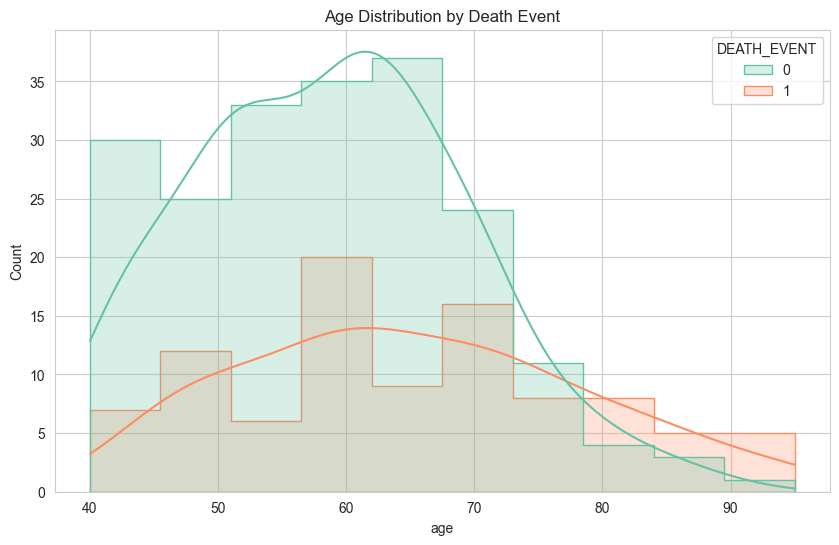

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='DEATH_EVENT', kde=True, element='step', palette='Set2')
plt.title('Age Distribution by Death Event')
plt.show()

## 5. 데이터 전처리 및 분할 (Scrub & Split)
모델 학습을 위해 데이터를 학습용(Train)과 테스트용(Test)으로 분리합니다.

In [8]:
# 특성(X)과 타겟(y) 분리
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

# 학습/테스트 데이터 분할 (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (239, 12)
Test set shape: (60, 12)


## 6. 모델링 (Model)
**Random Forest Classifier**를 사용하여 모델을 학습합니다.

In [9]:
# 모델 초기화 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print("Model training completed.")

Model training completed.


## 7. 모델 평가 및 해석 (Interpret)
테스트 세트를 사용하여 모델의 성능을 평가하고, 중요 변수(Feature Importance)를 확인합니다.

In [10]:
# 예측 수행
y_pred = rf_model.predict(X_test)

# 정확도 및 분류 보고서 출력
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8333

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        41
           1       0.80      0.63      0.71        19

    accuracy                           0.83        60
   macro avg       0.82      0.78      0.79        60
weighted avg       0.83      0.83      0.83        60



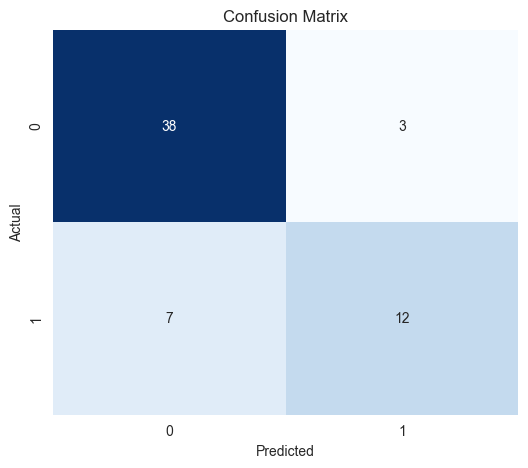

In [11]:
# 혼동 행렬 (Confusion Matrix) 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Feature Importance
모델이 예측에 중요하게 사용한 변수들을 시각화합니다.

/var/folders/7l/yp5d25zx7nb_92wbp8w2b0dw0000gn/T/ipykernel_60209/85116593.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_importances.index, palette='magma')


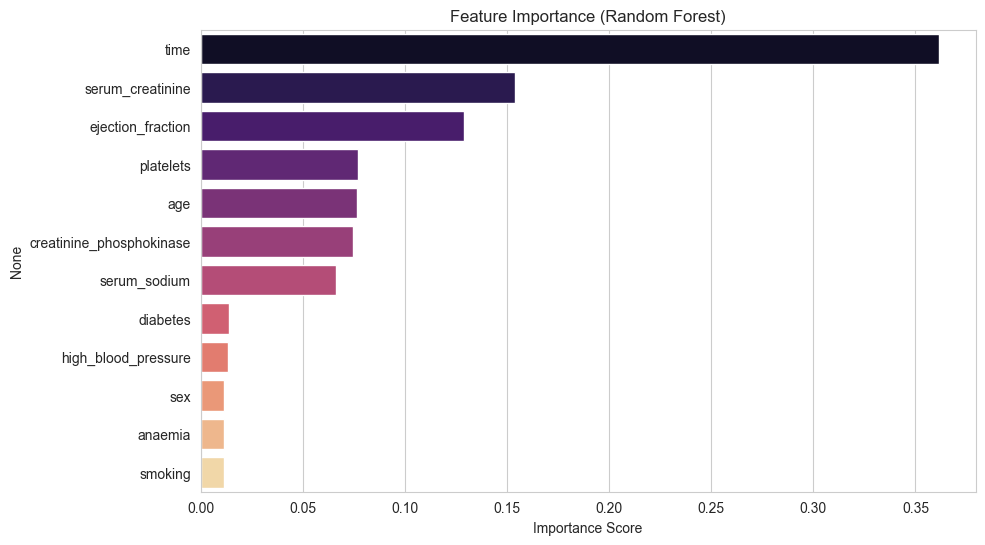

In [12]:
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index, palette='magma')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.show()

## 8. 결론 (Conclusion)
- Random Forest 모델을 통해 심부전 환자의 사망 여부를 예측했습니다.
- `time` (팔로업 기간), `serum_creatinine` (혈중 크레아티닌), `ejection_fraction` (박출률) 등이 주요한 예측 변수로 확인되었습니다.
- 초기 모델로서 유의미한 성능을 보였으나, 하이퍼파라미터 튜닝 등을 통해 추가적인 성능 향상이 가능할 것으로 보입니다.